In [2]:
#import libraries
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [4]:
#import bitcoin stock data 
csvpath = Path("BTC-USD.csv", parse_dates = True, infer_datetime_format = True,index_col="Date")
df = pd.read_csv(csvpath) 
df= df.drop(columns=["Open", "High","Low","Adj Close"])
df=df.set_index('Date')
df=df[['Volume','Close']]
df.tail()

,Volume,Close
Date,,
7/16/2020,1.032080e+11,9525.363281
7/23/2020,1.605610e+11,11100.467770
7/30/2020,1.441860e+11,11747.022460
8/6/2020,1.598130e+11,11584.934570
8/13/2020,5.176016e+10,11768.871090


data prep model LSTM RNN

In [43]:
#describe the data
df.describe()

,Volume,Close
count,2.940000e+02,294.000000
mean,5.608520e+10,4533.375081
std,7.986513e+10,4097.025769
min,1.094887e+08,178.102997
25%,4.969574e+08,544.278732
50%,1.828617e+10,3893.266358
75%,9.982654e+10,8009.071044
max,3.676060e+11,16624.599610


In [28]:
#function to fill arrays with data
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window -1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [33]:
#predict closing prices, used a window= 1, other options 5&10 day window of close/open prices
window_size = 1
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)


In [34]:
#split data 70%/30% of data for training
split = int(.7*len(X))
X_train = X[: split ]
X_test = X[split:]
y_train = y[: split ]
y_test = y[split:]

In [35]:
X_train.shape

(204, 1)

In [36]:
X_test.shape

(88, 1)

In [37]:
# Use MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [38]:
# Reshape the features for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print (f"X_train sample {X_train[:3]}")
print (f"X_test sample {X_train[:3]}")

X_train sample [[[0.0070674 ]]

 [[0.        ]]

 [[0.00296683]]]
X_test sample [[[0.0070674 ]]

 [[0.        ]]

 [[0.00296683]]]


In [39]:
#build and train LSTM RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [40]:
## Build the LSTM model
model = Sequential()
number_units = 5
dropout_fraction = .2
#1
model.add(LSTM(units= number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))
#2
model.add(LSTM(units = number_units, return_sequences= True))
model.add(Dropout(dropout_fraction))
#3
model.add(LSTM(units= number_units))
model.add(Dropout(dropout_fraction))
#outer
model.add(Dense(1))

In [41]:
#compile
model.compile(optimizer="adam", loss="mean_squared_error")

In [42]:
#summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 5)              140       
_________________________________________________________________
dropout (Dropout)            (None, 1, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 5)              220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [25]:
#train the model, epochs= 50, 
model.fit(X_train, y_train, epochs = 50, shuffle = False, batch_size=1, verbose = 1)

Epoch 1/50
204/204 [==============================] - 1s 3ms/step - loss: 0.0274
Epoch 2/50
204/204 [==============================] - 1s 3ms/step - loss: 0.0653
Epoch 3/50
204/204 [==============================] - 1s 3ms/step - loss: 0.0580
Epoch 4/50
204/204 [==============================] - 1s 3ms/step - loss: 0.0537
Epoch 5/50
204/204 [==============================] - 1s 3ms/step - loss: 0.0443
Epoch 6/50
204/204 [==============================] - 1s 3ms/step - loss: 0.0274
Epoch 7/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0133
Epoch 8/50
204/204 [==============================] - 1s 3ms/step - loss: 0.0139
Epoch 9/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0101
Epoch 10/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0096
Epoch 11/50
204/204 [==============================] - 1s 5ms/step - loss: 0.0105
Epoch 12/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0130
Epoch 13/50
204/204 [====

In [26]:
#evaluate
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.0036


0.00363424071110785

In [27]:
#predictions
predicted = model.predict(X_test)


In [28]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [29]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,3486.950195,3886.152832
1,3745.950684,3691.412598
2,3857.297607,3880.193604
3,3943.409424,3963.186523
4,4035.296387,4028.113525


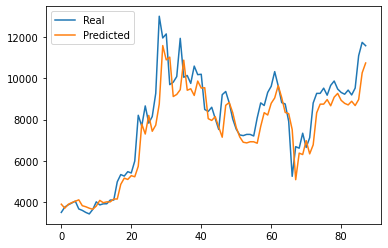

In [30]:
# Plot the real vs predicted values as a line chart
stocks.plot()

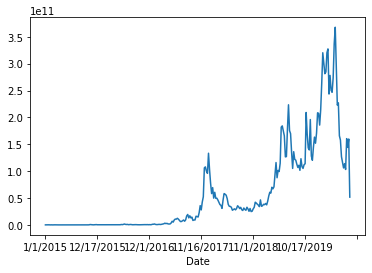

In [31]:
df['Volume'].plot()

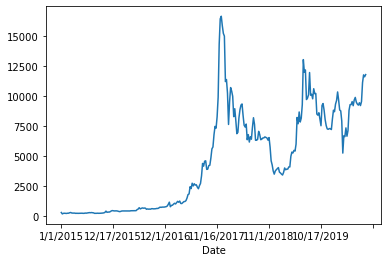

In [32]:
 df['Close'].plot()